## Todo
- eda midi file typ[e]
    - because of the bpm values not being missing, we know they're of type 1
- first 30 seconds?
    - chunk them out by 30 seconds to bootstrap
- add anomaly detection
- try some cross validation or other model effects (SVM)
    - functionalize some of the model evals
- more features 
    - get time signature from meta messages
    - stdev of velocity (instead of just average)
    - create some manual cross variables with timing and key and time sig

## Initial Imports and Paths

In [1]:
from composer_class_funcs import *

In [2]:
# viz
import matplotlib.pyplot as plt
import seaborn as sns
# ml packages
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [3]:
# file paths
train_midi_path = "./Challenge_DataSet/PS1/"
test_midi_path = "./Challenge_DataSet/PS2/"

print(os.listdir(train_midi_path))
print(os.listdir(test_midi_path))

['.DS_Store', 'Beethoven', 'Schubert', 'Bach', 'Brahms']
['0.8014751784512073_adj.mid', '0.981087291054314_adj.mid', '0.5807329043589801_adj.mid', '0.23120017256495873_adj.mid', '0.033313986422223163_adj.mid', '0.3559970176888735_adj.mid', '0.3264565808984162_adj.mid', '0.905499891236923_adj.mid', '0.10250888365879718_adj.mid', '0.48367685897240176_adj.mid', '0.549470161204349_adj.mid', '0.33695573887576447_adj.mid', '0.7491289879531658_adj.mid', '0.337517805339117_adj.mid', '0.07186746659481313_adj.mid', '0.09167358800381353_adj.mid', '0.539512676743813_adj.mid', '0.26551079719260606_adj.mid', '0.647959423719129_adj.mid', '0.047574444458241216_adj.mid', '0.10222964826466285_adj.mid', '0.22047111832936942_adj.mid', '0.1755252422917658_adj.mid', '0.36321860283443286_adj.mid', '0.21198476749665085_adj.mid', '0.06402123326764841_adj.mid', '0.3620067189216978_adj.mid', '0.9511403301279795_adj.mid', '0.1960551158929671_adj.mid', '0.21901852969811753_adj.mid', '0.10630249969742178_adj.mid', 

## Data Collection and Processing

In [4]:
features, labels = load_dataset(train_midi_path, labeled=True)
df_labeled = create_dataframe(features, labels)

In [5]:
unlabeled_features = load_dataset(test_midi_path, labeled=False)
df_unlabeled=create_dataframe(unlabeled_features)

## EDA

In [6]:
df_labeled.head()

,tpb,key,average_velocity,Note_0,Note_1,Note_2,Note_3,Note_4,Note_5,Note_6,...,Note_119,Note_120,Note_121,Note_122,Note_123,Note_124,Note_125,Note_126,Note_127,composer
0,384,Cm,96.794118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven
1,384,Dm,90.946108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven
2,384,Eb,80.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven
3,384,Cm,80.232558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven
4,384,G,80.692884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven


In [7]:
df_unlabeled.head()

,tpb,key,average_velocity,Note_0,Note_1,Note_2,Note_3,Note_4,Note_5,Note_6,...,Note_118,Note_119,Note_120,Note_121,Note_122,Note_123,Note_124,Note_125,Note_126,Note_127
0,192,F,75.930435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,96,Eb,69.800000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,120,C,53.905128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,384,A,76.966667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,384,Bm,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Display basic information about the DataFrame
print("\nBasic Information about the DataFrame:")
print(df_labeled.info())

# Generate summary statistics
print("\nSummary Statistics of the DataFrame:")
print(df_labeled.describe())

# Check for missing values
print("\nMissing Values in the DataFrame:")
print(df_labeled.isnull().sum())


Basic Information about the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Columns: 132 entries, tpb to composer
dtypes: float64(129), int64(1), object(2)
memory usage: 200.2+ KB
None

Summary Statistics of the DataFrame:
               tpb  average_velocity  Note_0  Note_1  Note_2  Note_3  Note_4  \
count   194.000000        194.000000   194.0   194.0   194.0   194.0   194.0   
mean    349.567010         78.222697     0.0     0.0     0.0     0.0     0.0   
std     129.871112         14.951558     0.0     0.0     0.0     0.0     0.0   
min     120.000000         36.000000     0.0     0.0     0.0     0.0     0.0   
25%     384.000000         68.503012     0.0     0.0     0.0     0.0     0.0   
50%     384.000000         80.207583     0.0     0.0     0.0     0.0     0.0   
75%     384.000000         86.954459     0.0     0.0     0.0     0.0     0.0   
max    1024.000000        127.000000     0.0     0.0     0.0     0.0     0.0   

       Note_5  Note_

In [9]:
df_labeled.key.value_counts()

key
Eb     28
C      28
       16
F      14
Bb     14
E      13
Ab     13
G      11
D      10
A      10
Cm      8
Fm      6
Dm      4
Em      4
Bm      3
Gm      3
Db      2
Am      1
F#m     1
C#m     1
F#      1
Bbm     1
Abm     1
Gb      1
Name: count, dtype: int64

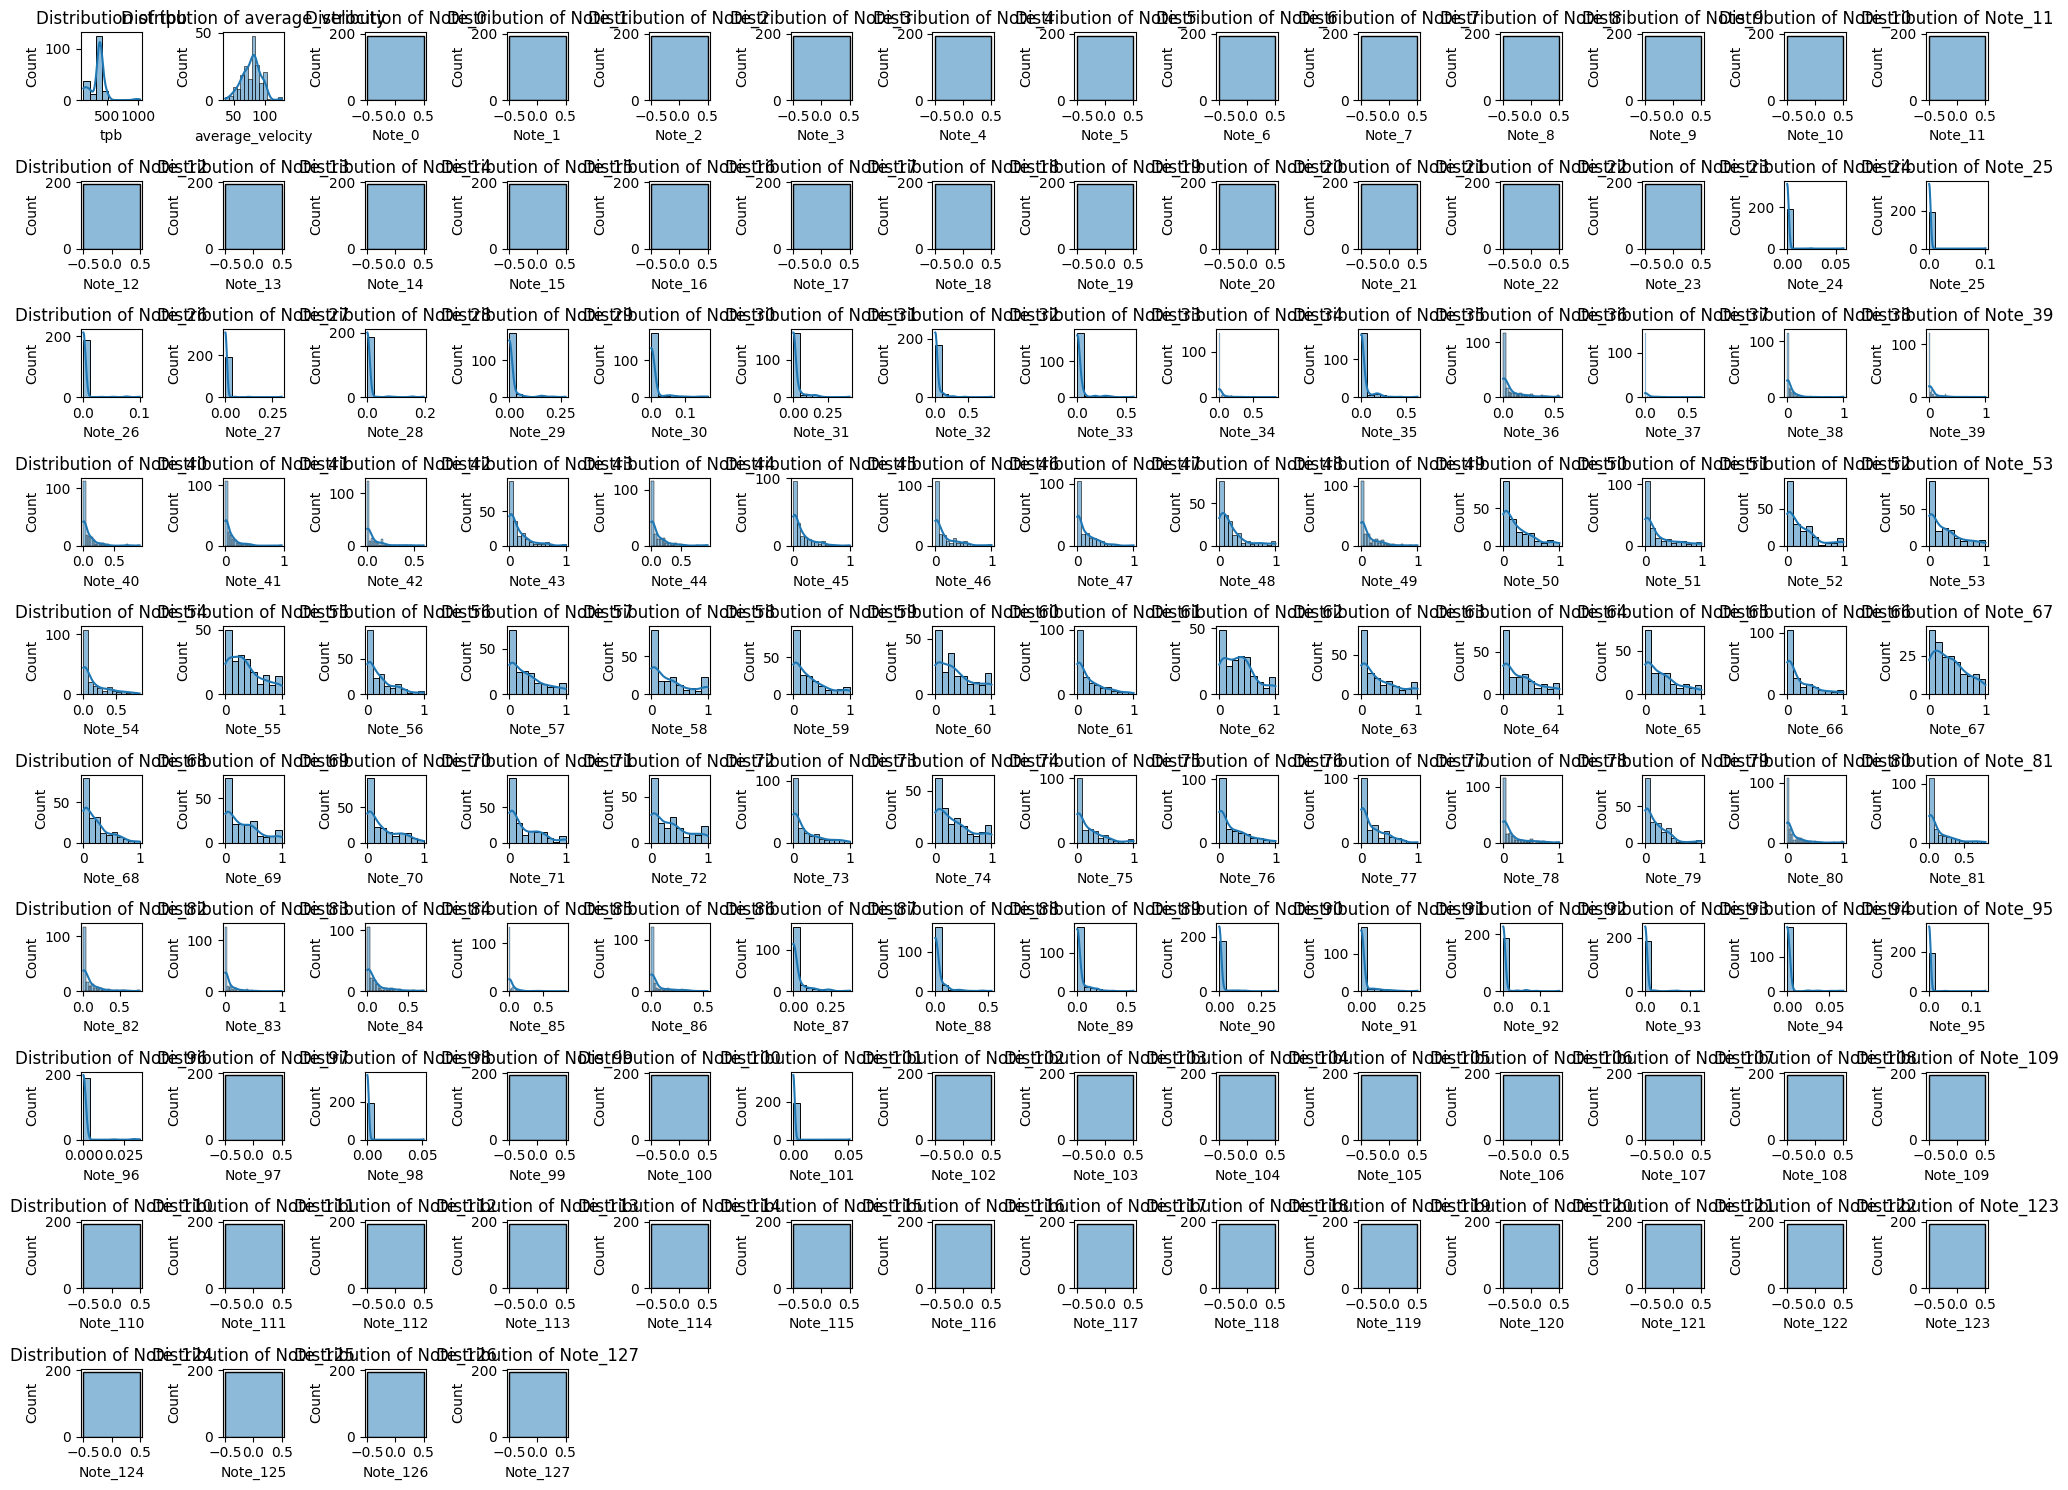

In [10]:
# Visualize the distribution of each numeric feature
numeric_columns = df_labeled.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_columns):
    plt.subplot(10, 14, i+1)
    sns.histplot(df_labeled[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

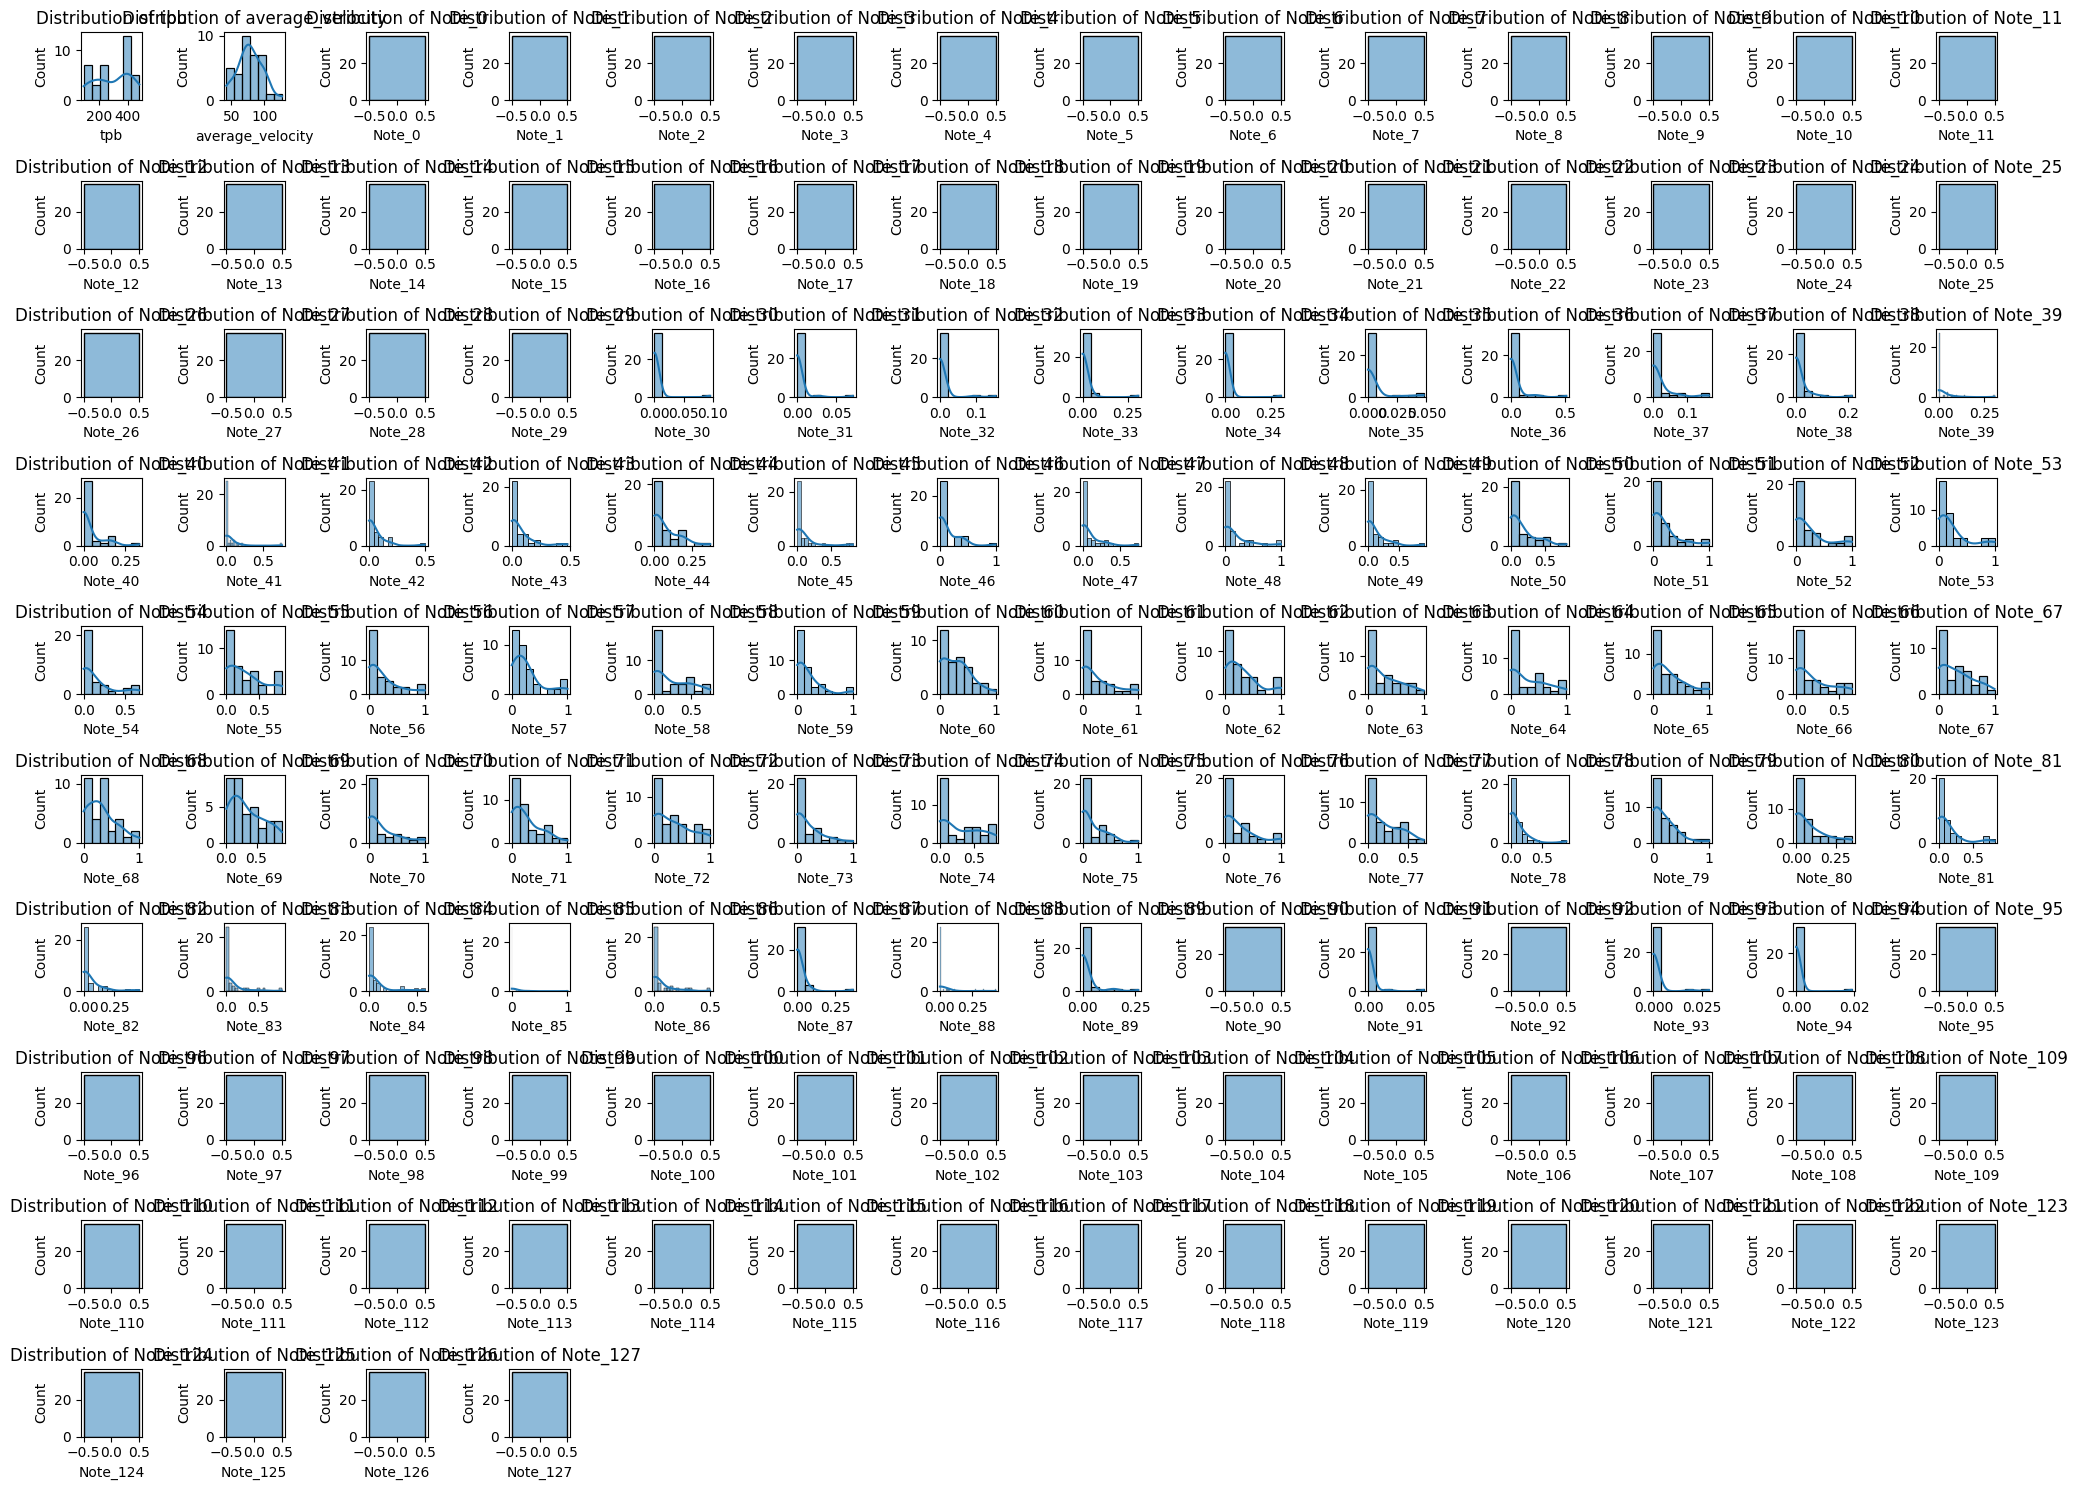

In [11]:
# Visualize the distribution of each numeric feature
numeric_columns = df_unlabeled.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_columns):
    plt.subplot(10, 14, i+1)
    sns.histplot(df_unlabeled[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

based on this, I'd remove notes 0-22, 105-127, unless we want to add back in for novelty detection

In [12]:
# Drop columns corresponding to notes 0-22 and 105-127
cols_to_drop = [f'Note_{i}' for i in list(range(0, 23)) + list(range(105, 128))]
df_labeled.drop(columns=cols_to_drop, inplace=True)

numeric_columns = df_labeled.select_dtypes(include=['float64', 'int64']).columns

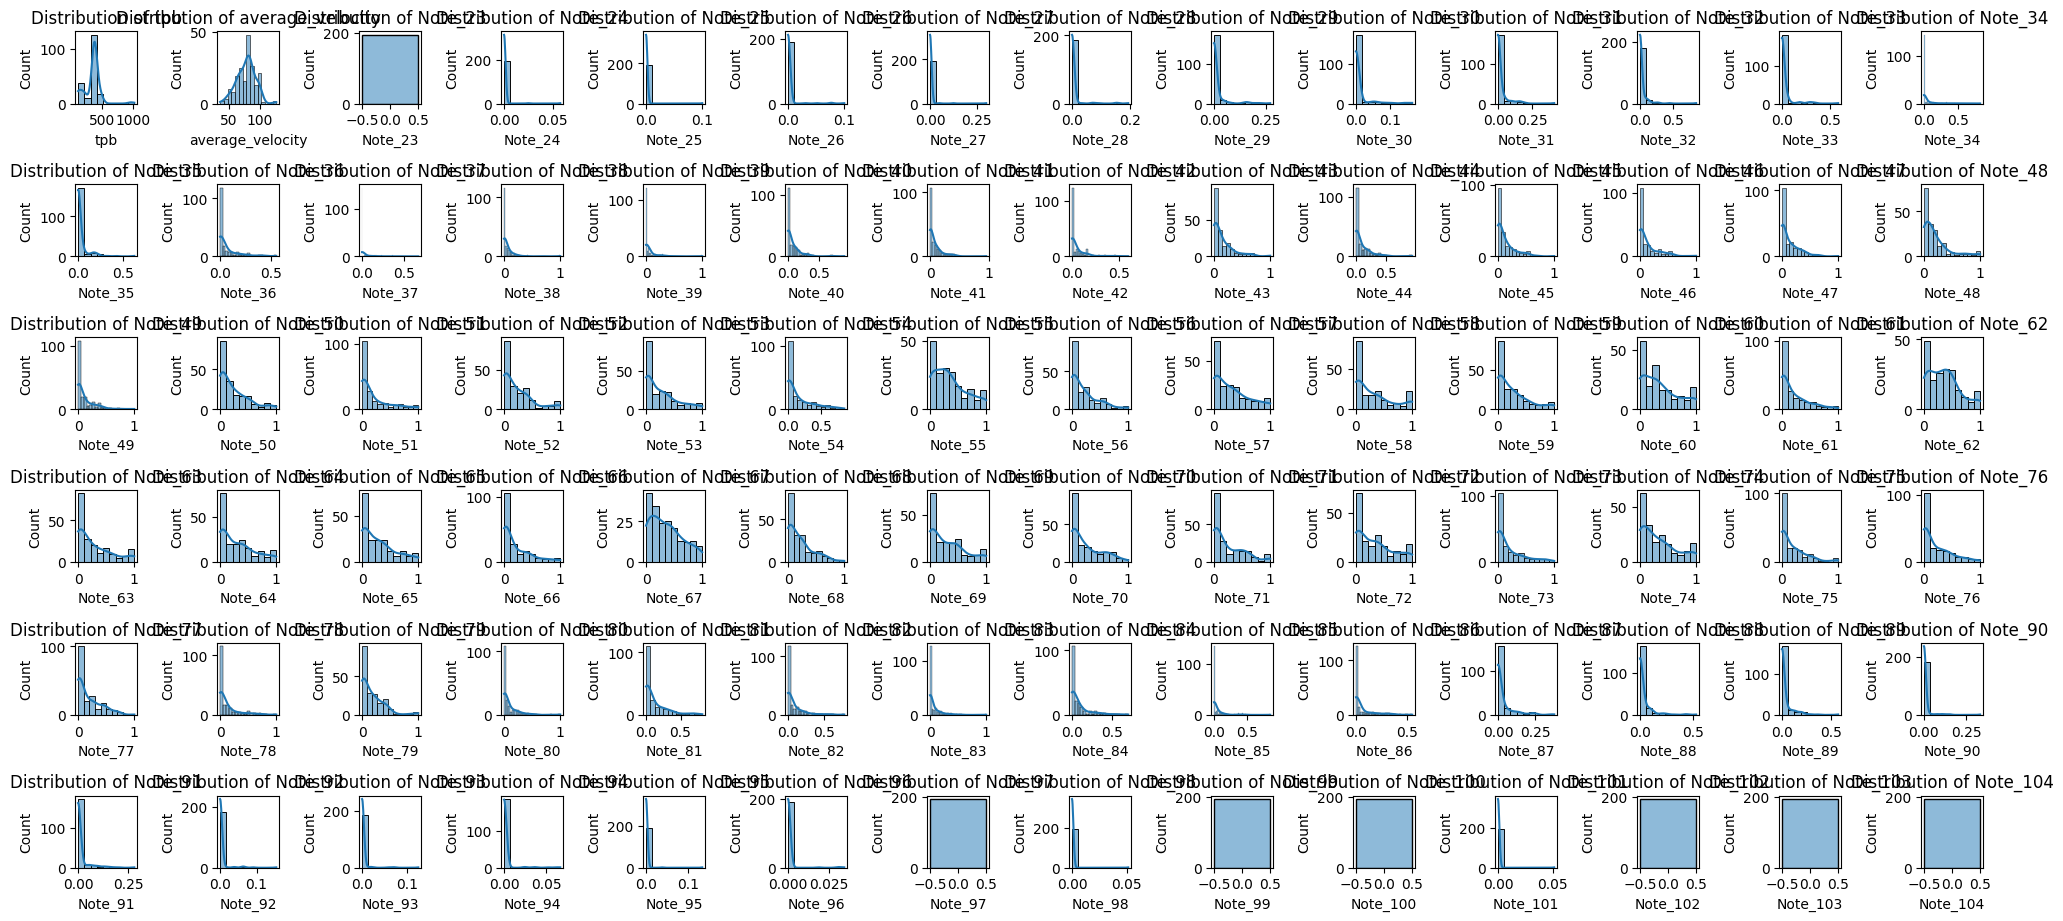

In [13]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_columns):
    plt.subplot(10, 14, i+1)
    sns.histplot(df_labeled[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

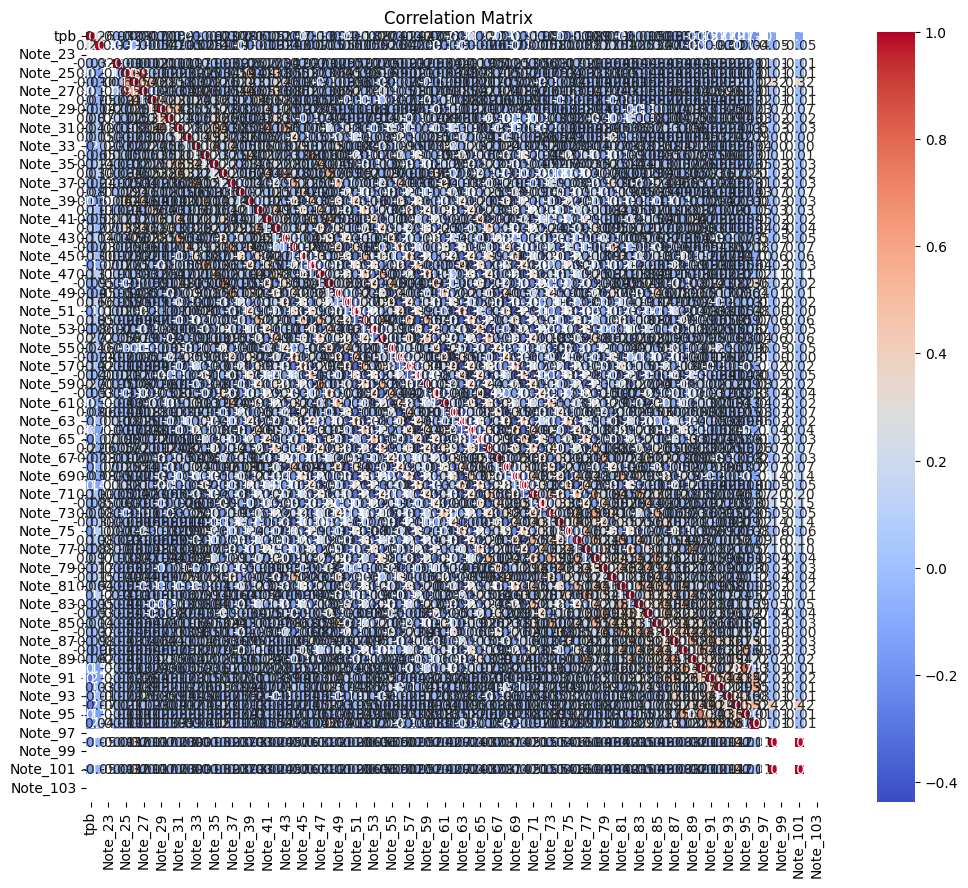

In [14]:
# Visualize correlations between numeric features
plt.figure(figsize=(12, 10))
correlation_matrix = df_labeled[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

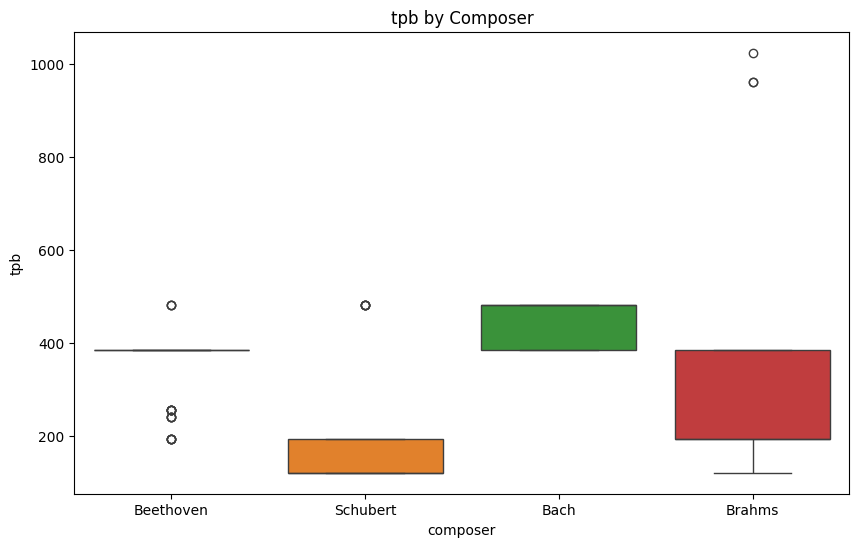

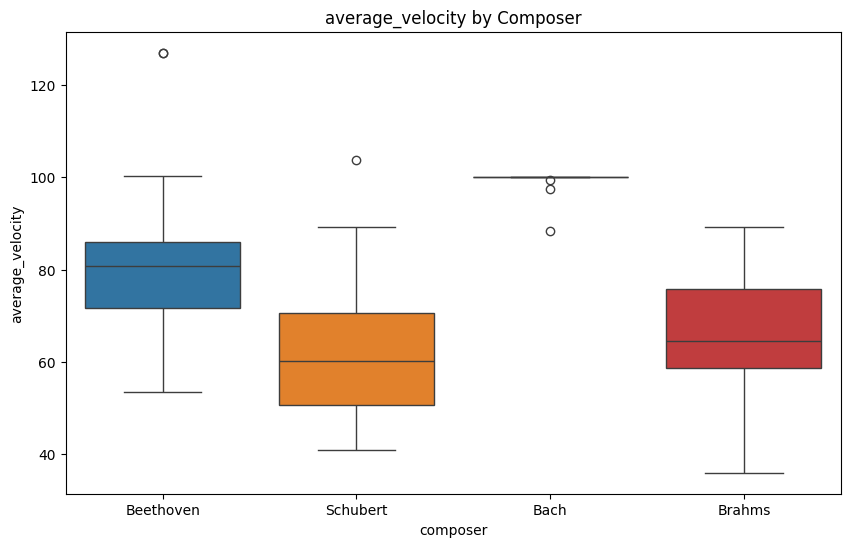

In [15]:
# Visualize the relationship between the first two numeric features and the target (if applicable)
if 'composer' in df_labeled.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='composer', y=numeric_columns[0], data=df_labeled, hue='composer')
    plt.title(f'{numeric_columns[0]} by Composer')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='composer', y=numeric_columns[1], data=df_labeled, hue='composer')
    plt.title(f'{numeric_columns[1]} by Composer')
    plt.show()

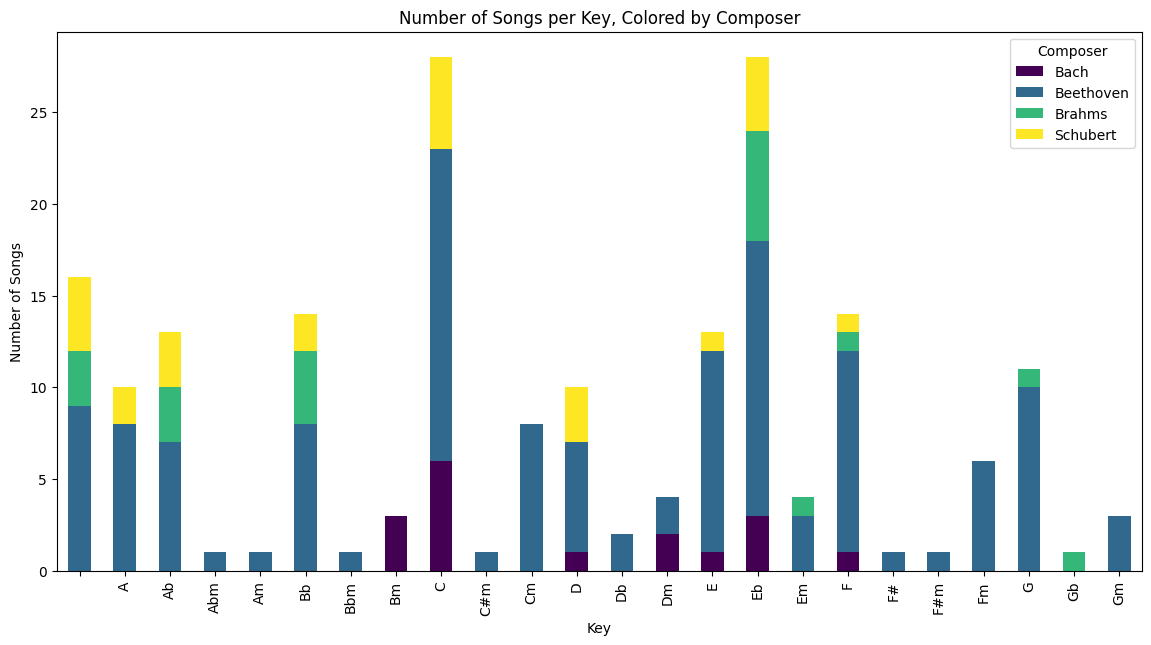

In [16]:
# Prepare the data for the stacked bar chart
key_composer_counts = df_labeled.groupby(['key', 'composer']).size().unstack(fill_value=0)
# Plot the stacked bar chart
key_composer_counts.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')
plt.title('Number of Songs per Key, Colored by Composer')
plt.xlabel('Key')
plt.ylabel('Number of Songs')
plt.xticks(rotation=90)
plt.legend(title='Composer')
plt.show()


## Clean + Feature engineer

In [17]:
# replace Null keys with 'unk' value
df_labeled['key']=df_labeled['key'].fillna('unk')

# Encode the 'key' variable
label_encoder_key = LabelEncoder()
df_labeled['key_encoded'] = label_encoder_key.fit_transform(df_labeled['key'])

# Encode the 'Composer' column
label_encoder_composer = LabelEncoder()
df_labeled['composer'] = label_encoder_composer.fit_transform(df_labeled['composer'])

In [18]:
# Define the features (X) and target (y)
X = df_labeled.drop(columns=['composer', 'key'])
y = df_labeled['composer']

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [20]:
print(label_encoder_composer.classes_,'\n')
print('train targets\n',y_train.value_counts())
print('\ntest targets\n',y_test.value_counts())

['Bach' 'Beethoven' 'Brahms' 'Schubert'] 

train targets
 composer
1    77
3    16
2    15
0     8
Name: count, dtype: int64

test targets
 composer
1    55
3     9
0     9
2     5
Name: count, dtype: int64


## Train Classifiers

### Logistic Regression

In [23]:
# Train and evaluate the Logistic Regression model
log_reg = LogisticRegression(max_iter=10000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
# Get the classification probabilities for each class
y_proba_lr = log_reg.predict_proba(X_test)

/Users/bartmasters/code/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
# def model_eval(classifier_name, y_test, y_pred, y_proba, label_encoder):
#     print(classifier_name,':')
#     print("Accuracy Score:", accuracy_score(y_test, y_pred))
#     print("\nClassification Report:")
#     print(classification_report(y_test, y_pred,))

#     # Print the classification probabilities along with the predicted class
#     # for i, probs in enumerate(y_proba):
#     #     print(f"Sample {i}:")
#     #     for j, class_prob in enumerate(probs):
#     #         print(f"  Class {label_encoder.classes_[j]}: {class_prob:.4f}")
#     #     print(f"  Predicted Class: {label_encoder.inverse_transform([y_pred_lr[i]])[0]}\n")

#     # Visualize the classification probabilities for each class
#     class_labels = label_encoder.classes_
#     num_classes = len(class_labels)

#     plt.figure(figsize=(14, 10))
#     for i in range(num_classes):
#         plt.subplot(num_classes, 1, i+1)
#         sns.histplot(y_proba[:, i], kde=True, bins=20)
#         plt.title(f'Class {class_labels[i]}: Probability Distribution')
#         plt.xlabel('Predicted Probability')
#         plt.ylabel('Frequency')
#     plt.tight_layout()
#     plt.show()

#     # Plot ROC curves for each class
#     plt.figure(figsize=(14, 10))
#     for i in range(num_classes):
#         fpr, tpr, thresholds = roc_curve(y_test == i, y_proba[:, i])
#         roc_auc = auc(fpr, tpr)
#         plt.plot(fpr, tpr, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})')
#     plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random guess
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic (ROC) Curves')
#     plt.legend(loc='best')
#     plt.show()

Logistic Regression :
Accuracy Score: 0.7948717948717948

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.56      0.71         9
           1       0.82      0.98      0.89        55
           2       0.00      0.00      0.00         5
           3       0.60      0.33      0.43         9

    accuracy                           0.79        78
   macro avg       0.60      0.47      0.51        78
weighted avg       0.76      0.79      0.76        78



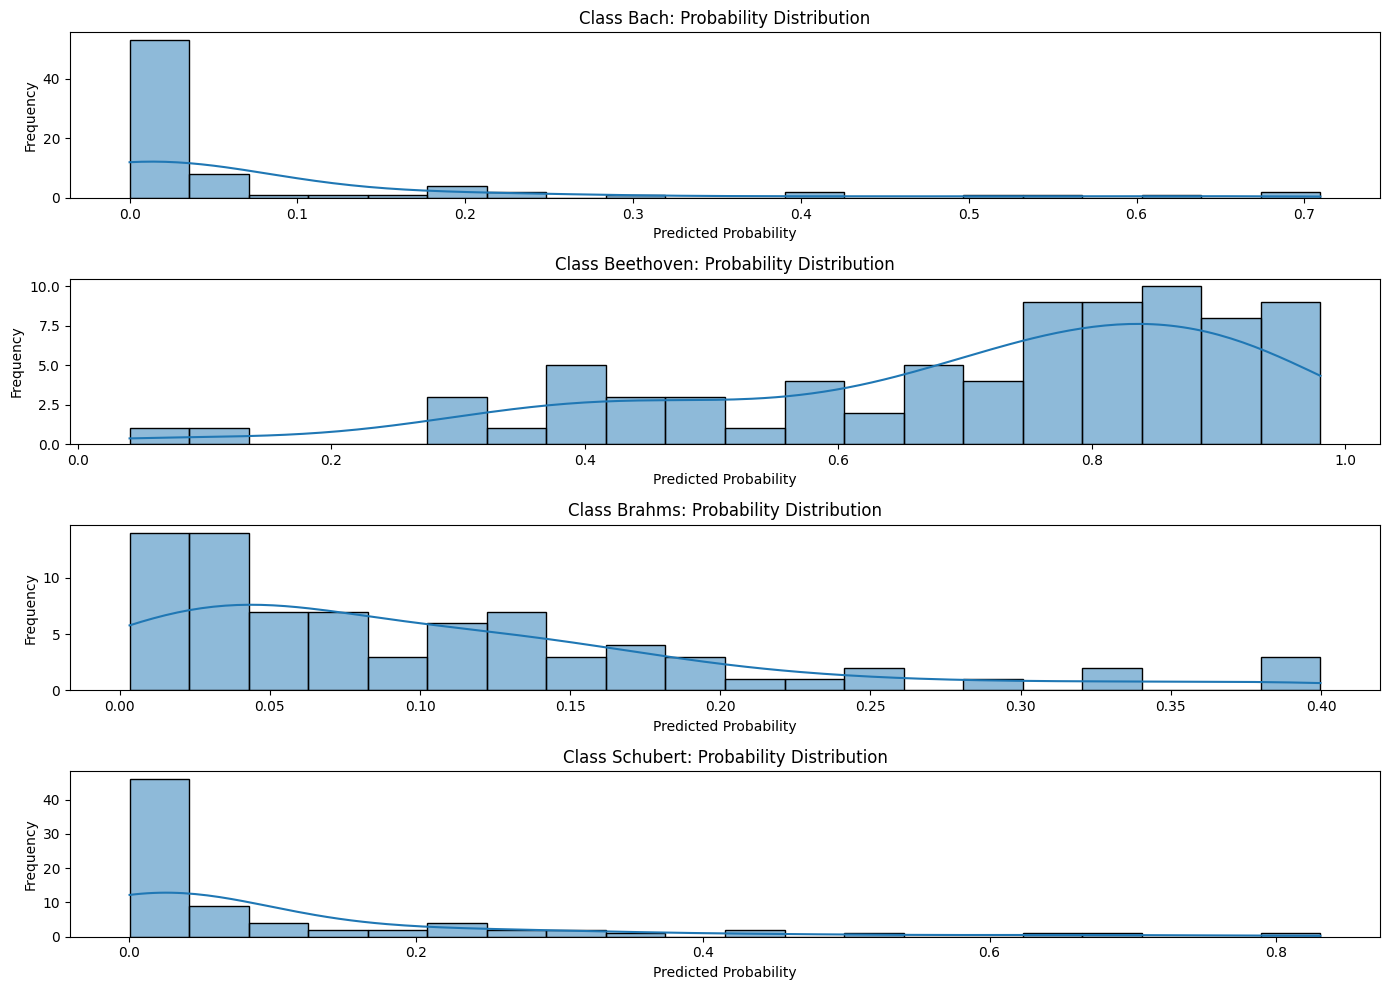

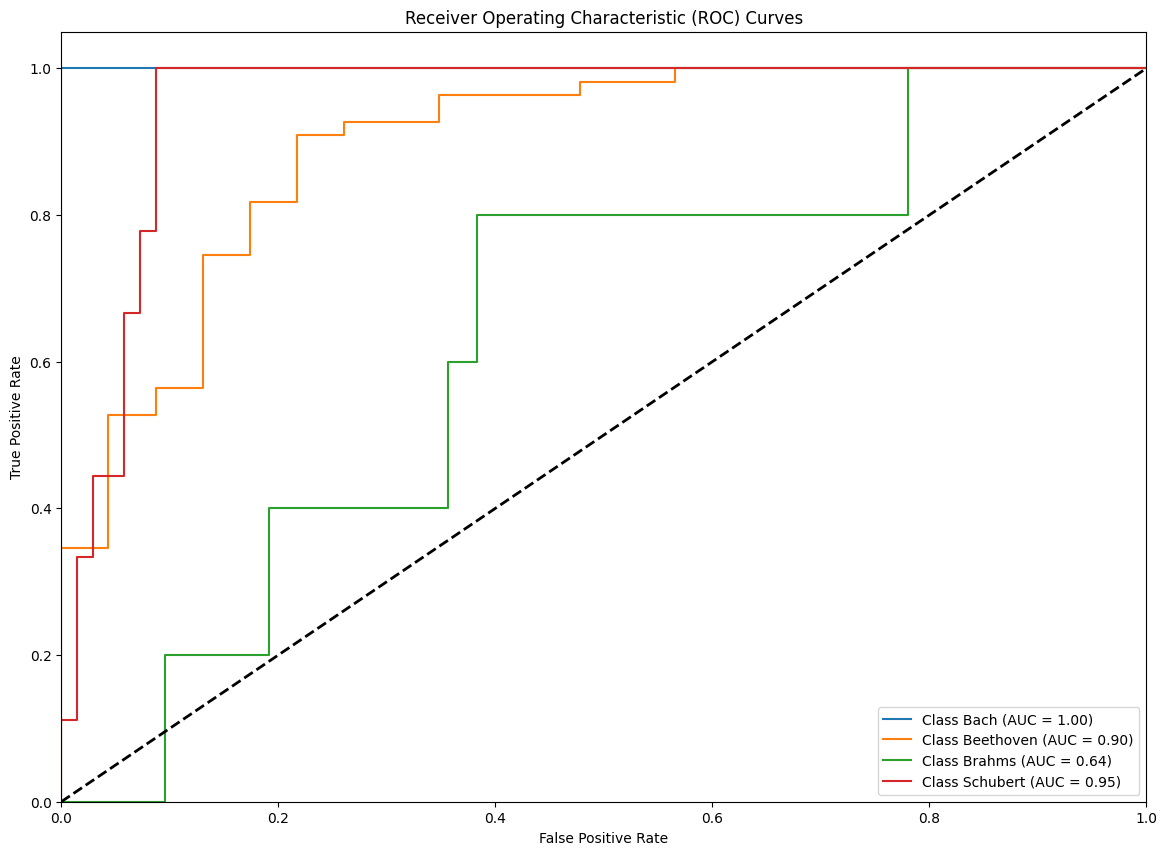

In [35]:
model_eval("Logistic Regression", y_test, y_pred_lr, y_proba_lr, label_encoder_composer)

### Random Forest

In [37]:
# Build and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
# Predict the target on the test set
y_pred_rf = rf_classifier.predict(X_test)
# Get the classification probabilities for each class
y_proba_rf = rf_classifier.predict_proba(X_test)

RandomForestClassifier(random_state=42)

Random Forest :
Accuracy Score: 0.7692307692307693

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.44      0.62         9
           1       0.79      1.00      0.88        55
           2       0.00      0.00      0.00         5
           3       1.00      0.11      0.20         9

    accuracy                           0.77        78
   macro avg       0.70      0.39      0.42        78
weighted avg       0.78      0.77      0.71        78



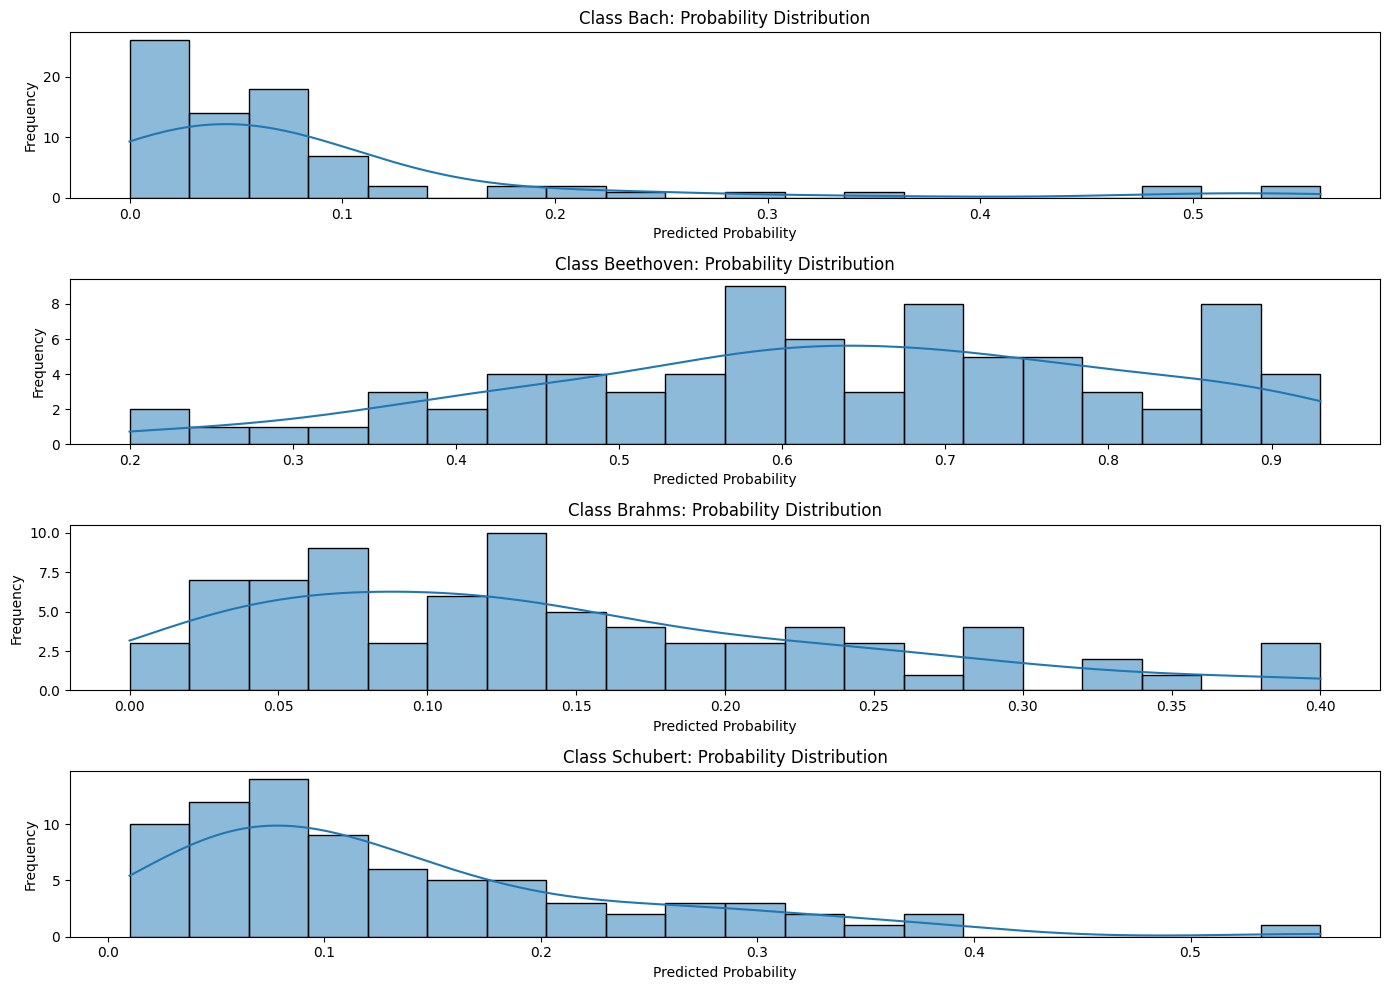

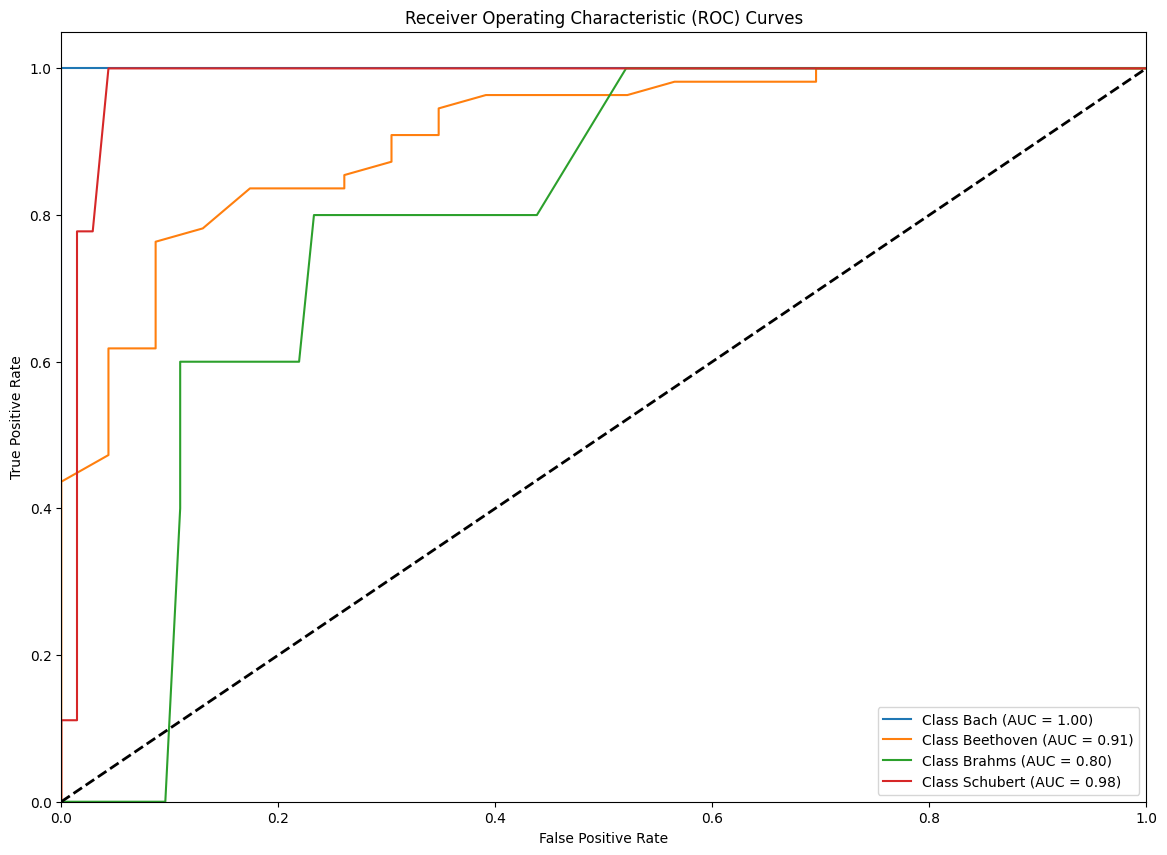

In [39]:
model_eval("Random Forest", y_test, y_pred_rf, y_proba_rf, label_encoder_composer)

## Inference

In [ ]:
# def predict_composer(file_path, classifier):
#     features = extract_features_from_midi(file_path)
#     prediction = classifier.predict([features])
#     return prediction[0]

# # Example usage
# new_midi_file = 'new_piece.mid'
# composer = predict_composer(new_midi_file, clf)
# print(f"The predicted composer is: {composer}")


# scratch

In [ ]:
file_path_ps2 = test_midi_path+"0.981087291054314_adj.mid"
file_path_ps1 = train_midi_path+"Bach/Cello Suite 3_BWV1009_2217_cs3-1pre.mid"

In [ ]:
x = extract_features_from_midi(file_path_ps1)

In [ ]:
midi = mido.MidiFile(file_path_ps1)

# initialize values
note_counts = [0] * 128  # MIDI notes range from 0 to 127
total_velocity = 0
note_on_count = 0
elapsed_time = 0
key = '' # each file should have only 1 key. Investigate if this assumption is correct.
tpb = midi.ticks_per_beat

# get ticks
# for track in midi.tracks:
for msg in midi:
    # get the key
    if msg.is_meta and msg.type == 'key_signature':
        key = msg.key
    
    # just the first n seconds
    elapsed_time += msg.time
    if elapsed_time<=30:
        if msg.type == 'note_on' and msg.velocity > 0:
            note_counts[msg.note] += 1
            total_velocity += msg.velocity
            note_on_count += 1
    else:
        break

print(note_counts)
print(elapsed_time)

In [ ]:
midi = mido.MidiFile(file_path_ps1)
print('Midi file type', midi.type)
print('Length',midi.length)
print('Ticks per beat',midi.ticks_per_beat)

ticks_per_beat = midi.ticks_per_beat

In [ ]:
# Load the MIDI file
midi_file = mido.MidiFile(file_path_ps1)

# Initialize a variable to keep track of elapsed time
# elapsed_time = 0

# Define the duration in seconds for which we want to collect messages
target_duration = 30

# List to store the messages within the first 30 seconds
messages_within_duration = []

# Iterate through the messages in the MIDI file
for track in midi_file.tracks:
    elapsed_time = 0
    for message in track:
        elapsed_time += message.time
        if elapsed_time <= target_duration:
            print(elapsed_time)
            print(message)


# Display the collected messages
# for msg in messages_within_duration:
#     print(msg)

In [ ]:
tempo=5000
elapsed_time=0

for track in midi.tracks:
    # print(track)
    for msg in track:        
        if msg.type == 'set_tempo':
            tempo = msg.tempo
            print('Tempo:\t',tempo)

        calc_time = mido.tick2second(msg.time, ticks_per_beat, tempo)
        elapsed_time += calc_time
        print('msg.time\t',msg.time)
        print('calc time:\t', calc_time)
        print('Elapsed Time:\t',elapsed_time)        
        # if elapsed_time <= 30:
        #     print(msg.time)

In [ ]:
def exp_mido(file_path):
    midi = mido.MidiFile(file_path)
    print('Midi file type', midi.type)
    print('Length',midi.length)
    print('Ticks per beat',midi.ticks_per_beat)

    elapsed_time = 0
    ticks_per_beat = midi.ticks_per_beat
    tempo = 500000

    for msg in midi:
        if msg.type == 'set_tempo':
            tempo = msg.tempo

        elapsed_time += mido.tick2second(msg.time, ticks_per_beat, tempo)
        # print(elapsed_time)
        if elapsed_time <= 30:
            print(msg)

In [ ]:
exp_mido(file_path_ps1)

In [ ]:
exp_mido(file_path_ps2)

In [ ]:
# # Generate the heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(composer_avg, cmap='viridis', cbar=True)

# # Display the plot
# plt.title('Composer Note Values Heatmap')
# plt.xlabel('Notes')
# plt.ylabel('Composers')
# plt.show()

In [ ]:
# # Transform the DataFrame into a long format
# df_long = pd.melt(composer_avg.reset_index(), id_vars=['Composer'], var_name='Note', value_name='Value')

# # Plot the bar chart
# plt.figure(figsize=(15, 8))
# sns.barplot(x='Note', y='Value', hue='Composer', data=df_long)

# # Customize the plot
# plt.title('Composer Note Values Bar Chart')
# plt.xlabel('Notes')
# plt.ylabel('Values')
# plt.legend(title='Composer')
# plt.xticks(rotation=90)  # Rotate x-axis labels if needed for better readability

# # Display the plot
# plt.show()